# This Looks Like That There

Main training notebook.

In [1]:
import os
import sys
import time
import imp #imp.reload(module)

import numpy as np
from tqdm import trange
from icecream import ic

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf

import network
import experiment_settings 
import data_functions
import push_prototypes
import plots
import common_functions

In [2]:
__author__ = "Elizabeth A. Barnes and Randal J Barnes"
__version__ = "1 December 2021"

In [3]:
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 300.

## Print the detailed system info

In [4]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"tensorflow version = {tf.__version__}")

python version = 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
numpy version = 1.21.5
tensorflow version = 2.9.0


## Define experiment settings and directories

In [5]:
EXP_NAME = 'cold_fourteenday_precip'#'balanced_test'#initial_test'#'mjo'#'quadrants_testcase'

imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

imp.reload(common_functions)
model_dir, model_diagnostics_dir, vizualization_dir = common_functions.get_exp_directories(EXP_NAME)

## Define the network parameters

In [6]:
RANDOM_SEED          = settings['random_seed']
BATCH_SIZE_PREDICT   = settings['batch_size_predict']
BATCH_SIZE           = settings['batch_size']
NLAYERS              = settings['nlayers']
NFILTERS             = settings['nfilters']   
assert(len(NFILTERS)==NLAYERS)

NCLASSES             = settings['nclasses']
PROTOTYPES_PER_CLASS = settings['prototypes_per_class']
NPROTOTYPES          = np.sum(PROTOTYPES_PER_CLASS)

NEPOCHS              = settings['nepochs']
LR_INIT              = settings['lr']
LR_CALLBACK_EPOCH    = settings['lr_cb_epoch']
PATIENCE             = 100

## Initialize

In [7]:
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Get and process the data

(73000, 64, 161, 1)


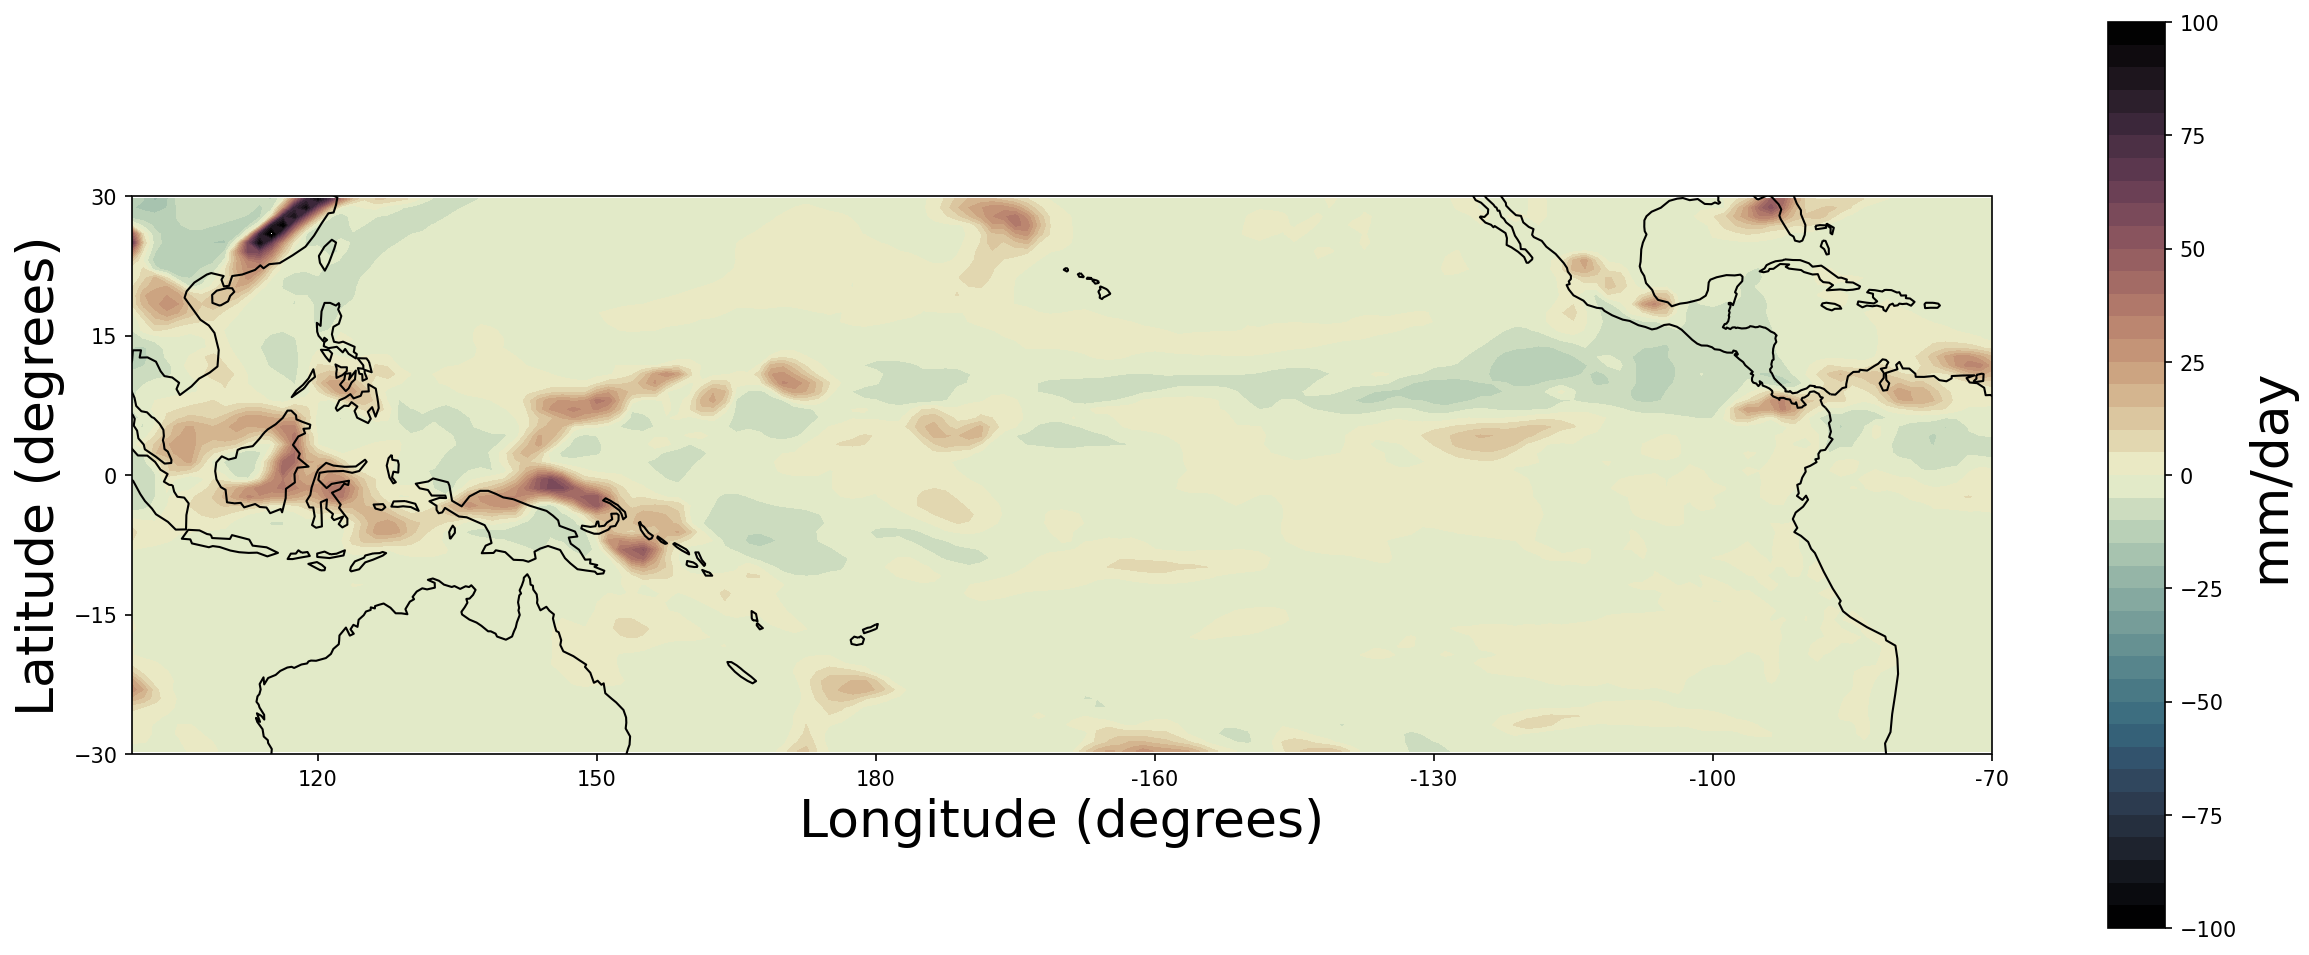

Mean: -0.00018878825206721645


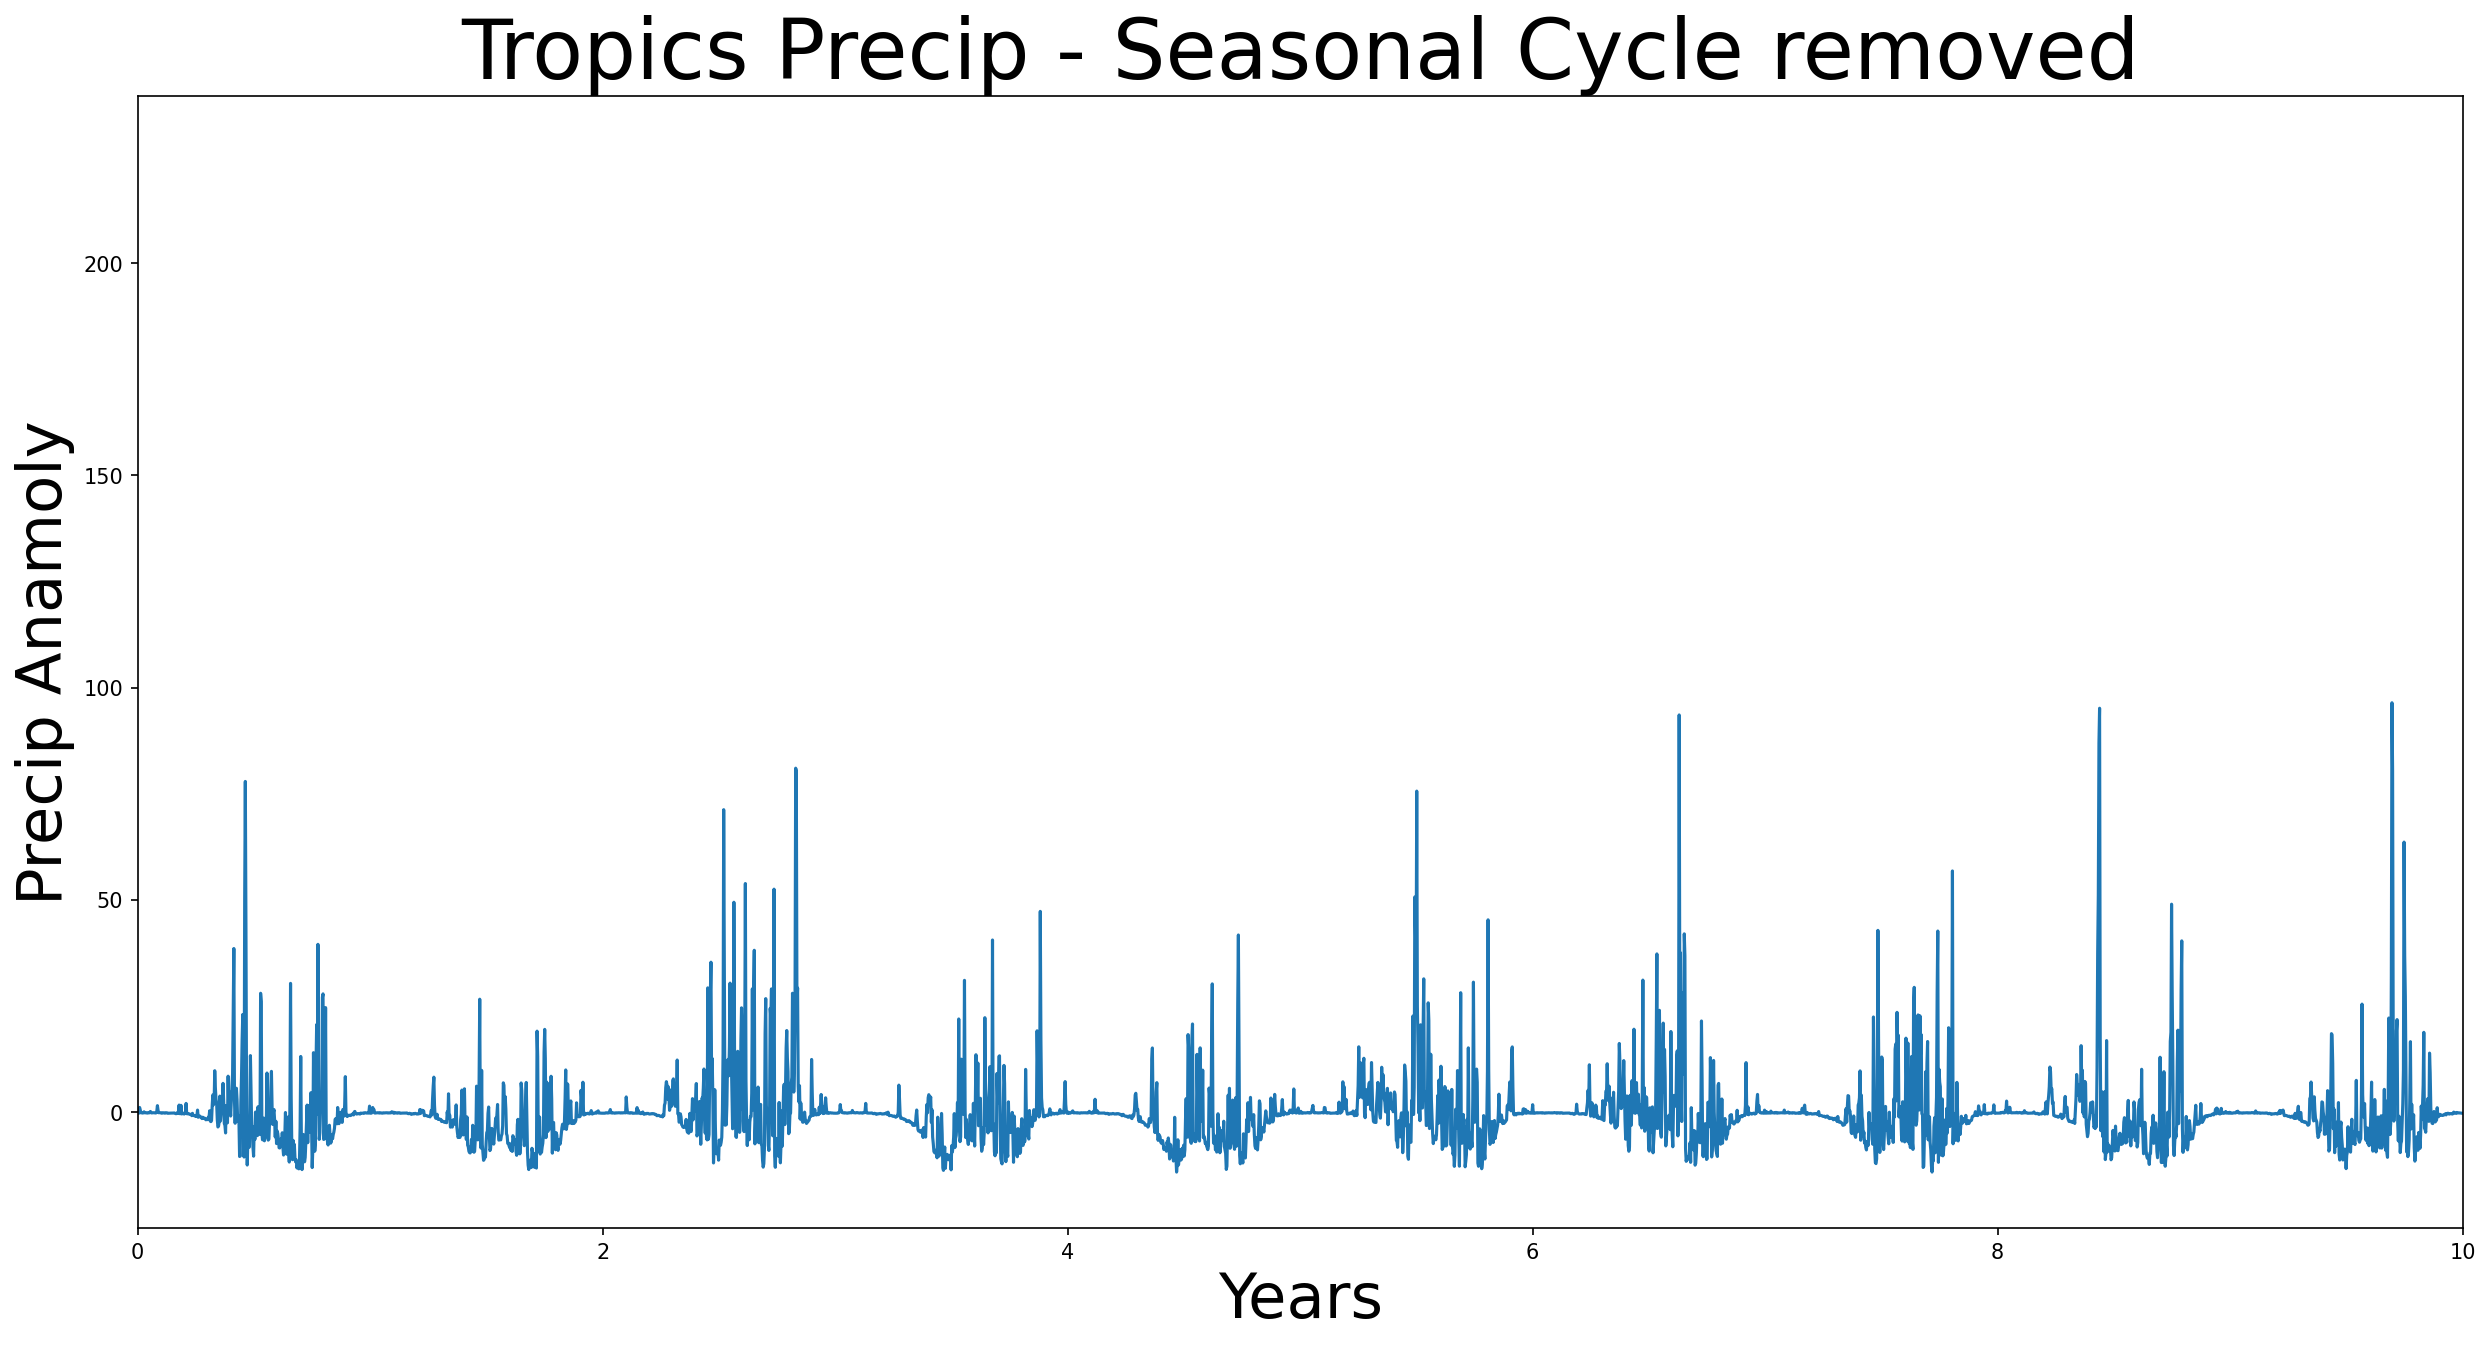

ic| years_train: array([1800, 1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810,
                        1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821,
                        1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832,
                        1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843,
                        1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854,
                        1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865,
                        1866, 1867, 1868, 1869])
ic| years_val: array([1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1880,
                      1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891,
                      1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902,
                      1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913,
                      1914, 1915, 1916, 1917, 1918, 1919])


raw_data        = (73000, 64, 161, 1)
training data   = (25550, 64, 161, 1), (25550,)
validation data = (18250, 64, 161, 1), (18250,)
test data       = (29200, 64, 161, 1), (29200,)
X_mean          = 0.00033996005676189205
X_std           = 7.5373001226835505


In [8]:
imp.reload(data_functions)
DATA_NAME = settings['data_name']
DATA_DIR = settings['data_dir']

# print(data_functions)

if(EXP_NAME[:3]=='mjo'):

    labels, data, lat, lon, time = data_functions.load_mjo_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_mjo_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )        
elif(EXP_NAME[:9]=='quadrants'):
    filename = DATA_DIR + DATA_NAME + '.mat'
    X_train, y_train, X_val, y_val, X_test, y_test, lat, lon = data_functions.get_and_process_data(filename, 
                                                                                        rng, 
                                                                                        colored=settings['colored'],
                                                                                        standardize=settings['standardize'],
                                                                                        shuffle=settings['shuffle'],
                                                                                        )      
elif((EXP_NAME[:12]=='initial_test') or (EXP_NAME[:12]=='smaller_test') or (EXP_NAME[:13]=='balanced_test') or (EXP_NAME[:13]=='threeday_test') or (EXP_NAME[:12]=='zeroday_test') or (EXP_NAME[:16]=='fourteenday_test') or (EXP_NAME[:18]=='fourteenday_precip') or (EXP_NAME[:19]=='seventeenday_precip') or (EXP_NAME[:16]=='elevenday_precip') or (EXP_NAME[:30]=='fixed_fourteenday_precip')or (EXP_NAME[:30]=='cold_fourteenday_precip')):

    labels, data, lat, lon, time = data_functions.load_pres_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_pres_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )
elif((EXP_NAME[:21]=='fourteenday_both_test') or ((EXP_NAME[:18]=='threeday_both_test'))):
    print("bingo")
    labels, data, lat, lon, time = data_functions.load_z500_precip_data(DATA_DIR)
    X_train, y_train, time_train, X_val, y_val, time_val, X_test, y_test, time_test = data_functions.get_and_process_pres_data(labels,
                                                                                         data,
                                                                                         time,
                                                                                         rng, 
                                                                                         colored=settings['colored'],
                                                                                         standardize=settings['standardize'],
                                                                                         shuffle=settings['shuffle'],
                                                                                        )

In [9]:
proto_class_mask = network.createClassIdentity(PROTOTYPES_PER_CLASS)

prototypes_of_correct_class_train = np.zeros((len(y_train),NPROTOTYPES))
for i in range(0,prototypes_of_correct_class_train.shape[0]):
    prototypes_of_correct_class_train[i,:] = proto_class_mask[:,int(y_train[i])]
    
prototypes_of_correct_class_val   = np.zeros((len(y_val),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_val.shape[0]):
    prototypes_of_correct_class_val[i,:] = proto_class_mask[:,int(y_val[i])]

prototypes_of_correct_class_test   = np.zeros((len(y_test),NPROTOTYPES))    
for i in range(0,prototypes_of_correct_class_test.shape[0]):
    prototypes_of_correct_class_test[i,:] = proto_class_mask[:,int(y_test[i])]
    

## Define the training callbacks and metrics

In [10]:
# callbacks
def scheduler(epoch, lr):
    if epoch < LR_CALLBACK_EPOCH:
        return np.round(lr,8)
    else:
        if(epoch % 2 == 0):
            return lr/2.
        else:
            return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)    
    
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_sparse_categorical_accuracy', 
    mode='max',
    patience=settings['patience'], 
    restore_best_weights=True, 
    verbose=1
)

callbacks_list = [
#     lr_callback,
#     es_callback,
]            

# metrics
metrics_list = [
    tf.keras.metrics.SparseCategoricalAccuracy(),
]

2022-09-22 12:13:08.259825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Instantiate the model

In [11]:
__ = imp.reload(network)
tf.keras.backend.clear_session()

model = network.build_model(
    nlayers              = NLAYERS,
    nfilters             = NFILTERS,
    input_shape          = X_train.shape[1:],
    output_shape         = NCLASSES,
    prototypes_per_class = PROTOTYPES_PER_CLASS,
    network_seed         = RANDOM_SEED,    
    prototype_channels   = settings['prototype_channels'],    
    coeff_cluster        = settings['coeff_cluster'],
    coeff_separation     = settings['coeff_separation'],
    coeff_l1             = settings['coeff_l1'],
    incorrect_strength   = settings['incorrect_strength'],
    double_conv          = settings['double_conv'],
    kernel_l1_coeff      = 0.0,#settings['kernel_l1_coeff'],
    kernel_l2_coeff      = 0.0,#settings['kernel_l2_coeff'],
    drop_rate            = 0.0,
    drop_rate_final      = 0.0,        
    
)
model.summary()

3
[16, 16, 16]
(64, 161, 1)
3
[10, 10, 10]
30
False
0.2
-0.02
0.1
-0.5
False
8
64
0.0
0.0
0.0
0.0
False
Model: "full_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 64, 161, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv_0 (Conv2D)                (None, 64, 161, 16)  160         ['inputs[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 64, 161, 16)  0           ['conv_0[0][0]']                 
                                                                                    

## Load pre-trained weights into convolutional layers

In [12]:
if(settings['pretrain'] == True):

    if(settings['pretrain_exp'] is None):
        PRETRAINED_MODEL = model_dir + 'pretrained_model_' + EXP_NAME 
    else:
        PRETRAINED_MODEL = './saved_models/' + settings['pretrain_exp'] 

    print('loading pretrained convolutional layers from ' + PRETRAINED_MODEL)
    pretrained_model = tf.keras.models.load_model(PRETRAINED_MODEL)

    for layer in range(1,len(model.layers)):
        if(model.layers[layer].name[:4]=='conv'):
            print('   loading pretrained weights for --> ' + model.layers[layer].name)
            model.layers[layer].set_weights(pretrained_model.layers[layer].get_weights())
else:
    print('no pretrained model specified. keeping random initialized weights.')
    

loading pretrained convolutional layers from ./saved_models/fixed_fourteenday_precip/pretrained_model_fixed_fourteenday_precip
   loading pretrained weights for --> conv_0
   loading pretrained weights for --> conv_1
   loading pretrained weights for --> conv_2


In [13]:
# raise ValueError('here')

***

# Run Training Stages

In [14]:
imp.reload(network)
imp.reload(plots)
imp.reload(push_prototypes)
imp.reload(experiment_settings)
settings = experiment_settings.get_settings(EXP_NAME)

In [15]:
ic(np.shape(X_train))
ic(np.shape(prototypes_of_correct_class_train))
ic(np.shape(prototypes_of_correct_class_train))

ic| np.shape(X_train): (25550, 64, 161, 1)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)
ic| np.shape(prototypes_of_correct_class_train): (25550, 30)


(25550, 30)

In [16]:
imp.reload(push_prototypes)
NEPOCHS    = settings['nepochs']
STAGE_LIST = (0,1,2,3,4,5,6,7,8,9)#range(len(NEPOCHS))#(1,2,3,4,5)#range(len(NEPOCHS))

for stage in STAGE_LIST:
    
    print('--------------------')
    print('TRAINING STAGE = ' + str(stage))
    print('--------------------')

    # load previously trained stage, unless it is the 0th stage
    if(stage != 0):
        tf.keras.backend.clear_session()
        model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage-1)
#         model = common_functions.load_model(model_filename)
        model.load_weights(model_filename)
        
    # learn layers (during even numbered stages)
    if(stage % 2 == 0):
        # train prototypes layers (and possibly CNN layers)
        if(settings['pretrain']==False and settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(settings['train_cnn_in_stage'] == False or stage==0):
            model = network.set_trainable_layers(model, [False,True,True,False])
        elif(settings['train_cnn_in_stage'] == True):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        elif(stage >= settings['train_cnn_in_stage']):
            model = network.set_trainable_layers(model, [True,True,True,False])            
        else:
            model = network.set_trainable_layers(model, [False,True,True,False])
    else:
        #.......................................................
        # push the prototypes
        #.......................................................        
        model, push_info = push_prototypes.push(model, 
                                                [X_train,prototypes_of_correct_class_train], 
                                                prototypes_of_correct_class_train, 
                                                perform_push=True,
                                                batch_size=BATCH_SIZE_PREDICT,
                                                verbose=False,
                                               )        
        print('Push complete.\n')            

        # train weights layer only
        model = network.set_trainable_layers(model, [False,False,False,True])        

    #.......................................................
    # compile the model
    #.......................................................
    if(stage>=settings['cut_lr_stage']):
        lr_factor = 10.**(np.floor((stage-settings['cut_lr_stage']+2)/2))
    else:
        lr_factor = 1.
    if(LR_INIT/lr_factor<settings['min_lr']):
        lr_factor = LR_INIT/settings['min_lr']
    print('learning rate = ' + str(np.asarray(LR_INIT/lr_factor,dtype='float32')))

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=np.asarray(LR_INIT/lr_factor,dtype='float32'), 
        ),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics = metrics_list,
    )
#     model.summary()
    ic(np.min(model.layers[-3].get_weights()[1]),np.max(model.layers[-3].get_weights()[1]))

    #.......................................................
    # train the model
    #.......................................................
    print('Training the model...')    
    
    tf.random.set_seed(RANDOM_SEED)   
    np.random.seed(RANDOM_SEED)    
    history = model.fit(
        [X_train,prototypes_of_correct_class_train],
        y_train,
        validation_data=([[X_val,prototypes_of_correct_class_val]], [y_val]),
        batch_size=BATCH_SIZE,
        epochs=NEPOCHS[stage],
        shuffle=True,
        verbose=1,
        callbacks=callbacks_list
    )
    print('Training complete.\n')            
        

    # save the model at this training stage
    model_filename = model_dir + 'model_' + EXP_NAME + '_stage' + str(stage)
    common_functions.save_model(model, model_filename) 
    
    #.......................................................
    # plot results
    #.......................................................  
    try:
        # plot loss history of the model
        plots.plot_loss_history(history)
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_loss_history_stage' + str(stage) + '.png', dpi=dpiFig)    
        plt.close()

        # plot the weights
        plots.plot_weights(model, PROTOTYPES_PER_CLASS)    
        plt.savefig(model_diagnostics_dir + EXP_NAME + '_weights_stage' + str(stage) + '.png', dpi=dpiFig)
        plt.close()
    except:
        print('not making plots...')
        plt.close()

ic| np.min(model.layers[-3].get_weights()[1]): 0.0
    np.max(model.layers[-3].get_weights()[1]): 0.0


--------------------
TRAINING STAGE = 0
--------------------
   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 33s 40ms/step - loss: 4.2156 - sparse_categorical_accuracy: 0.3510 - cluster_cost: 0.5123 - separation_cost: 0.4537 - l1_weights_cost: 3.0000 - val_loss: 4.1761 - val_sparse_categorical_accuracy: 0.3663 - val_cluster_cost: 0.3495 - val_separation_cost: 0.3193 - val_l1_weights_cost: 3.0000
Epoch 2/10
799/799 [==============================] - 27s 34ms/step - loss: 4.1577 - sparse_categorical_accuracy: 0.3634 - cluster_cost: 0.2470 - separation_cost: 0.2258 - l1_weights_cost: 3.0000 - val_loss: 4.1424 - val_sparse_categorical_accuracy: 0.3793 - val_cluster_cost: 0.2273 - val_separation_cost: 0.2

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0/assets


--------------------
TRAINING STAGE = 1
--------------------
Running Prototype Push


2022-09-22 12:18:09.681788: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage0; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 3s 312ms/step


ic| np.min(model.layers[-3].get_weights()[1]): -1.1979619
    np.max(model.layers[-3].get_weights()[1]): 2.8920557


Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 29s 35ms/step - loss: 3.0216 - sparse_categorical_accuracy: 0.3692 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.5417 - val_loss: 1.3020 - val_sparse_categorical_accuracy: 0.3500 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.1352
Epoch 2/10
799/799 [==============================] - 23s 29ms/step - loss: 1.1902 - sparse_categorical_accuracy: 0.3653 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0573 - val_loss: 1.2312 - val_sparse_categorical_accuracy: 0.3624 - val_cluster_cost: 0.0000e+00 - val_sepa

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1/assets
2022-09-22 12:22:26.136832: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.1979619
    np.max(model.layers[-3].get_weights()[1]): 2.8920557


--------------------
TRAINING STAGE = 2
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.01
Training the model...
Epoch 1/10
799/799 [==============================] - 66s 81ms/step - loss: 1.1179 - sparse_categorical_accuracy: 0.3797 - cluster_cost: 0.0461 - separation_cost: 0.0265 - l1_weights_cost: 0.0214 - val_loss: 1.1185 - val_sparse_categorical_accuracy: 0.3846 - val_cluster_cost: 0.0396 - val_separation_cost: 0.0213 - val_l1_weights_cost: 0.0214
Epoch 2/10
799/799 [==============================] - 60s 75ms/step - loss: 1.1095 - sparse_categorical_accuracy: 0.3989 - cluster_cost: 0.0298 - separation_cost: 0.0182 - l1_weights_cost: 0.0214 - val_loss: 1.1130 - val_sparse_categorical_accuracy: 0.4040 - val_cluster_cost: 0.0273 - val_separation_cost: 0.0188 - 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2/assets


--------------------
TRAINING STAGE = 3
--------------------
Running Prototype Push


2022-09-22 12:32:28.001387: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage2; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 3s 306ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.01


ic| np.min(model.layers[-3].get_weights()[1]): -1.8138136
    np.max(model.layers[-3].get_weights()[1]): 4.3672233


Training the model...
Epoch 1/10
799/799 [==============================] - 27s 33ms/step - loss: 1.5426 - sparse_categorical_accuracy: 0.3666 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0388 - val_loss: 1.3558 - val_sparse_categorical_accuracy: 0.3494 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0369
Epoch 2/10
799/799 [==============================] - 23s 29ms/step - loss: 1.4007 - sparse_categorical_accuracy: 0.3593 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0265 - val_loss: 1.4987 - val_sparse_categorical_accuracy: 0.3436 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0197
Epoch 3/10
799/799 [==============================] - 22s 28ms/step - loss: 1.4359 - sparse_categorical_accuracy: 0.3640 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0295 - val_loss: 1.4716 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3/assets
2022-09-22 12:36:46.621003: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage3; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.8138136
    np.max(model.layers[-3].get_weights()[1]): 4.3672233


--------------------
TRAINING STAGE = 4
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 0.001
Training the model...
Epoch 1/10
799/799 [==============================] - 64s 79ms/step - loss: 1.1271 - sparse_categorical_accuracy: 0.3622 - cluster_cost: 0.0087 - separation_cost: 0.0043 - l1_weights_cost: 0.0231 - val_loss: 1.1264 - val_sparse_categorical_accuracy: 0.3661 - val_cluster_cost: 0.0084 - val_separation_cost: 0.0023 - val_l1_weights_cost: 0.0231
Epoch 2/10
799/799 [==============================] - 57s 72ms/step - loss: 1.1080 - sparse_categorical_accuracy: 0.3995 - cluster_cost: 0.0082 - separation_cost: 0.0033 - l1_weights_cost: 0.0231 - val_loss: 1.1224 - val_sparse_categorical_accuracy: 0.3649 - val_cluster_cost: 0.0068 - val_separation_cost: 0.0030 -

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4/assets


--------------------
TRAINING STAGE = 5
--------------------
Running Prototype Push


2022-09-22 12:46:32.888924: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage4; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 3s 316ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 0.001


ic| np.min(model.layers[-3].get_weights()[1]): -1.8367792
    np.max(model.layers[-3].get_weights()[1]): 4.2440233


Training the model...
Epoch 1/10
799/799 [==============================] - 28s 34ms/step - loss: 1.1044 - sparse_categorical_accuracy: 0.3879 - cluster_cost: 2.9033e-05 - separation_cost: 2.1962e-06 - l1_weights_cost: 0.0059 - val_loss: 1.1273 - val_sparse_categorical_accuracy: 0.3672 - val_cluster_cost: 3.6290e-05 - val_separation_cost: 2.0897e-06 - val_l1_weights_cost: 0.0054
Epoch 2/10
799/799 [==============================] - 23s 29ms/step - loss: 1.0970 - sparse_categorical_accuracy: 0.4000 - cluster_cost: 2.9033e-05 - separation_cost: 2.2207e-06 - l1_weights_cost: 0.0055 - val_loss: 1.1218 - val_sparse_categorical_accuracy: 0.3604 - val_cluster_cost: 3.6290e-05 - val_separation_cost: 2.0897e-06 - val_l1_weights_cost: 0.0057
Epoch 3/10
799/799 [==============================] - 23s 28ms/step - loss: 1.1023 - sparse_categorical_accuracy: 0.3941 - cluster_cost: 2.9033e-05 - separation_cost: 2.1962e-06 - l1_weights_cost: 0.0053 - val_loss: 1.1327 - val_sparse_categorical_accuracy: 

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5/assets
2022-09-22 12:50:51.453138: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage5; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.8367792
    np.max(model.layers[-3].get_weights()[1]): 4.2440233


--------------------
TRAINING STAGE = 6
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-04
Training the model...
Epoch 1/10
799/799 [==============================] - 63s 77ms/step - loss: 1.0808 - sparse_categorical_accuracy: 0.3851 - cluster_cost: 4.5150e-04 - separation_cost: 3.0777e-05 - l1_weights_cost: 0.0055 - val_loss: 1.1082 - val_sparse_categorical_accuracy: 0.3703 - val_cluster_cost: 5.9476e-04 - val_separation_cost: 3.8107e-05 - val_l1_weights_cost: 0.0055
Epoch 2/10
799/799 [==============================] - 57s 72ms/step - loss: 1.0783 - sparse_categorical_accuracy: 0.4174 - cluster_cost: 7.6309e-04 - separation_cost: 7.5148e-05 - l1_weights_cost: 0.0055 - val_loss: 1.1065 - val_sparse_categorical_accuracy: 0.3707 - val_cluster_cost: 7.9356e-04 - v

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6/assets


--------------------
TRAINING STAGE = 7
--------------------
Running Prototype Push


2022-09-22 13:01:29.069027: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage6; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 3s 312ms/step


ic| np.min(model.layers[-3].get_weights()[1]): -1.8530695
    np.max(model.layers[-3].get_weights()[1]): 4.2389774


Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-04
Training the model...
Epoch 1/10
799/799 [==============================] - 29s 35ms/step - loss: 1.0735 - sparse_categorical_accuracy: 0.4027 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0020 - val_loss: 1.1062 - val_sparse_categorical_accuracy: 0.3742 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0016
Epoch 2/10
799/799 [==============================] - 25s 31ms/step - loss: 1.0726 - sparse_categorical_accuracy: 0.4177 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0015 - val_loss: 1.0995 - val_sparse_categorical_accuracy: 0.3836 - val_cluster_cost: 0.0000e+00 - val_sep

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7/assets
2022-09-22 13:06:02.961359: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage7; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
ic| np.min(model.layers[-3].get_weights()[1]): -1.8530695
    np.max(model.layers[-3].get_weights()[1]): 4.2389774


--------------------
TRAINING STAGE = 8
--------------------
   conv_0 --> True
   maxpooling_0 --> True
   conv_1 --> True
   maxpooling_1 --> True
   conv_2 --> True
   maxpooling_2 --> True
   first_1x1_conv --> True
   second_1x1_conv --> True
   prototype --> True
   final_weights --> False
learning rate = 1e-05
Training the model...
Epoch 1/10
799/799 [==============================] - 66s 81ms/step - loss: 1.0690 - sparse_categorical_accuracy: 0.4082 - cluster_cost: 1.9097e-08 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0011 - val_loss: 1.0974 - val_sparse_categorical_accuracy: 0.3838 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 0.0011
Epoch 2/10
799/799 [==============================] - 60s 75ms/step - loss: 1.0689 - sparse_categorical_accuracy: 0.4270 - cluster_cost: 3.8195e-08 - separation_cost: 0.0000e+00 - l1_weights_cost: 0.0011 - val_loss: 1.0973 - val_sparse_categorical_accuracy: 0.3839 - val_cluster_cost: 0.0000e+00 - v

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8/assets


--------------------
TRAINING STAGE = 9
--------------------
Running Prototype Push


2022-09-22 13:16:42.723194: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8: FAILED_PRECONDITION: saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage8; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


9/9 [==============================] - 3s 320ms/step
Performing push of prototypes.
Push complete.

   conv_0 --> False
   maxpooling_0 --> False
   conv_1 --> False
   maxpooling_1 --> False
   conv_2 --> False
   maxpooling_2 --> False
   first_1x1_conv --> False
   second_1x1_conv --> False
   prototype --> False
   final_weights --> True
learning rate = 1e-05


ic| np.min(model.layers[-3].get_weights()[1]): -1.8568417
    np.max(model.layers[-3].get_weights()[1]): 4.238773


Training the model...
Epoch 1/10
799/799 [==============================] - 29s 36ms/step - loss: 1.0685 - sparse_categorical_accuracy: 0.4079 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 7.4573e-04 - val_loss: 1.0967 - val_sparse_categorical_accuracy: 0.3854 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 7.2885e-04
Epoch 2/10
799/799 [==============================] - 25s 31ms/step - loss: 1.0683 - sparse_categorical_accuracy: 0.4255 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 5.9088e-04 - val_loss: 1.0971 - val_sparse_categorical_accuracy: 0.3831 - val_cluster_cost: 0.0000e+00 - val_separation_cost: 0.0000e+00 - val_l1_weights_cost: 5.3140e-04
Epoch 3/10
799/799 [==============================] - 24s 31ms/step - loss: 1.0683 - sparse_categorical_accuracy: 0.4265 - cluster_cost: 0.0000e+00 - separation_cost: 0.0000e+00 - l1_weights_cost: 5.4554e-04 - val_loss: 1.0965 - val_sparse_ca

INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage9/assets


INFO:tensorflow:Assets written to: ./saved_models/fixed_fourteenday_precip/model_fixed_fourteenday_precip_stage9/assets


In [17]:
"

SyntaxError: EOL while scanning string literal (1845220801.py, line 1)

In [ ]:
"test""test""test""test""test"